# Main file for the project



ruben está editando este archivo.

#### A.Simule el comportamiento del aeropuerto durante un mes y estime las principales medidas de rendimiento del mismo 
**tiempos medios y máximos de espera de los aviones para aterrizar y despegar**
(tiempo medio y máximo de espera antes de entrar a N1)
t_med_espera_aterrizaje
t_max_espera_aterrizaje
t_med_espera_despegue
t_max_espera_despegue

- LISTA{tLL1, tS1, tS2, tS3} / length(LISTA)

**número medio de aviones en el aeropuerto**
(número medio de clientes en el sistema)
n_med_total

- n_med_n1 + n_med_n2 + n_med_n3

**% de tiempo que están ocupadas las pistas** 
(tiempo de ocupación de N1)
tiempo_ocupacion_pista1
tiempo_ocupacion_pista2
tiempo_ocupacion_pista3

- (tiempo_ocupacion_n1 / tiempo_total) * 100

#### Variables propuestas

- t ≡ tiempo transcurrido de simulación 
- n1, n2, n3 ≡ nº de clientes en el nodo 1, 2 y 3 (var. de estado). 

- NLL1, NLL2, NLL3 ≡ nº de llegadas al primer, segundo y tercer nodo hasta el instante t (variables contador). 
- NS1, NS2, NS3 ≡ nº de salidas del primer, segundo y tercer nodo hasta el instante t (variables contador). 

- LISTA{tLL1, tS1, tS2, tS3, tSS} ≡ registro con cinco elementos en los que guardamos el instante en el que ocurrirá cada evento. 
- LLj(i), Sj(i) ≡ instante en el que llega/sale el cliente i-ésimo al/del servidor j-ésimo, j=1,2,3, respectivamente.

## Env Set-Up

#### Imports

In [48]:
import random

#### Función getlambda0

In [49]:
def getlambda0(t):
    # t está en minutos, convertir a horas:
    t = t/60
    # Intervalo de 0 a 5 horas, lineal de 5 a 7
    if 0 <= t < 5:
        return 5 + (7 - 5) * (t - 0) / (5 - 0)
    # Intervalo de 5 a 8 horas, lineal de 7 a 6
    elif 5 <= t < 8:
        return 7 + (6 - 7) * (t - 5) / (8 - 5)
    # Intervalo de 8 a 15 horas, lineal de 6 a 9
    elif 8 <= t < 15:
        return 6 + (9 - 6) * (t - 8) / (15 - 8)
    # Intervalo de 15 a 17 horas, lineal de 9 a 6
    elif 15 <= t < 17:
        return 9 + (6 - 9) * (t - 15) / (17 - 15)
    # Intervalo de 17 a 24 horas, lineal de 6 a 5
    elif 14 <= t <= 24:
        return 6 + (5 - 6) * (t - 17) / (24 - 17)
    # Si el tiempo está fuera del rango de 0 a 24 horas
    else:
        return None  


#### Parámetros de simulación

In [50]:
T = 24*60 # 24h en minutos

nPistas = 3
nCoches = 20
nPuertas = 50

lambda0 = getlambda0
mu11 = 10
sigma11 = 3
a12 = 10
b12 = 15
lambda2 = 2
lambda3 = 0.1

#### Inicialización de variables

In [55]:
t = 0                   # Variable reloj. tiempo asíncrono.
n1 = n2 = n3 = 0        # Variables de estado nº clientes
NLL1 = NLL2 = NLL3 = 0  # Variables contador nº llegadas
NS1 = NS2 = NS3 = 0     # Variables contador nº salidas

# Lista de tiempos de eventos
LISTA = {
    'tLL1': -1, 'tS1': -1, 'tS2': -1, 'tS3': -1, 'tSS': -1
}  

# Arrays for arrival and departure times
LL1 = []
LL2 = []
LL3 = []
S1 = []
S2 = []
S3 = []

n_med_n1 = n_med_n2 = n_med_n3 = 0

n_cola_aterrizaje = 0 # Contador de aviones esperando para aterrizar


#### Gráfica de getlambda0

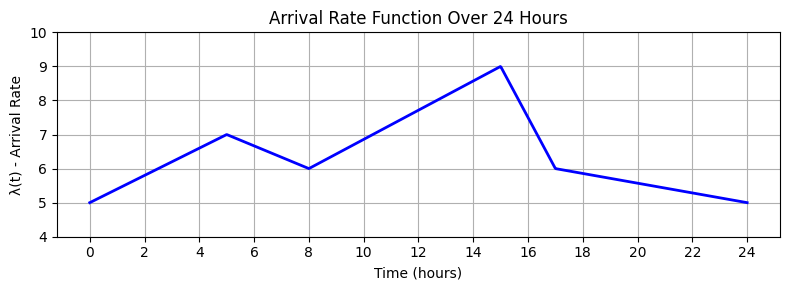

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create time points array (0 to 24*60 minutes)
t = np.linspace(0, 24*60, 1000)

# Calculate lambda values for each time point
lambda_values = [getlambda0(ti) for ti in t]

# Create the plot
plt.figure(figsize=(8, 3))
plt.plot(t/60, lambda_values, 'b-', linewidth=2)
plt.grid(True)
plt.xlabel('Time (hours)')
plt.ylabel('λ(t) - Arrival Rate')
plt.title('Arrival Rate Function Over 24 Hours')
# Set x-axis ticks for every hour
plt.xticks(range(0, 25, 2))
plt.yticks(range(4, 11, 1))

plt.tight_layout()
plt.show()


## Rutinas auxiliares

**Nodo 1**
- Primera llegada: rutina_aterrizaje
- Resto de llegadas: rutina_aterrizaje o rutina_despegue (si la cola de aterrizaje esta vacia)
- Salida: Si rutina_aterrizaje -> rutina_traslado, Si rutina_despegue nada

**Nodo 2**
- llegada: rutina_traslado
- salida: rutina_desembarque

**Nodo 3**
- llegada: rutina_desembarque
- salida: rutina_despegue

In [56]:
def rutina_aterrizaje(t_suc, n_cola_aterrizaje):
    global t, n1, n2, n3, NLL1, LL1, LISTA
    global n_med_n1, n_med_n2, n_med_n3
    
    # para luego calcular numero medio de clientes
    n_med_n1 += n1 * (t_suc - t)
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)
    
    # Actualizo variables contadores
    n1 += 1                 # aviones en n1
    NLL1 += 1               # numero de llegadas al n1
    LL1[NLL1] = t_suc       # Guardo el tiempo del evento en la lista de tiempos LL1
    t = t_suc               # Actualizo reloj asíncrono

    # Genero tiempo siguente aterrizaje
    Y = random.expovariate(getlambda0(t))

    # Compruebo si el siguiente avión llega antes de T
    if (t + Y < T):
        LISTA['tLL1'] = t + Y
    
    # Si es el primer avión que llega, le genero un tiempo de traslado
    if (n1==1):
        Y = random.normalvariate(mu11, sigma11)
        LISTA['tS1']= t + Y

    # TODO

    return 

In [40]:
def rutina_despegue(t_suc):
    global t, n1, n2, n3, NS1
    global n_med_n1, n_med_n2, n_med_n3

    # para luego calcular numero medio de clientes
    n_med_n1 += n1 * (t_suc - t)
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)

    # Actualizo variables contadoras
    n1 -= 1                 # aviones en n1
    NS1 += 1                # nº salidas de n1
    t = t_suc               # Actualizo reloj asíncrono

    return 

In [ ]:
def rutina_traslado(t_suc):
    global t, n1, n2, n3, NS1 , NLL2, LL2, LISTA
    global n_med_n1, n_med_n2, n_med_n3

    # para luego calcular numero medio de clientes
    n_med_n1 += n1 * (t_suc - t)
    n_med_n2 += n2 * (t_suc - t)
    n_med_n3 += n3 * (t_suc - t)

    # Actualizo variables contadoras
    n1 -= 1                 # aviones en n1
    nS1 += 1                # numero de salidas del n1
    n2 += 1                 # aviones en n2
    NLL2 += 1               # numero de llegadas al n2
    LL2[NLL2] = t_suc       # Guardo el tiempo del evento en la lista de tiempos LL1
    t = t_suc               # Actualizo reloj asíncrono

## Simulación 1

In [43]:
def simul_main(T,
                nPistas, nCoches, nPuertas, 
                lambda0, mu11, sigma11, a12, b12, lambda2, lambda3):
    

    X = random.expovariate(lambda0) # tiempo hasta la primera llegada

    # Caso especial X > T
    if (X>T):
        
        # medidas de rendimiento a 0
        performance_metrics = {
            'tiempos': {
                'aterrizaje': {'medio': 0, 'max': 0},
                'despegue': {'medio': 0, 'max': 0}
            },
            'n_medio_aviones': 0,
            'porcentaje_ocupacion': {
                'pista1': 0,
                'pista2': 0,
                'pista3': 0
            }
        }
        return performance_metrics, -1
    else:
        # TODO
        rutina_aterrizaje(X, nPistas)

        # Mientras t<=T y haya un cliente en el sistema
        while (t<=T and ((LISTA['tLL1'] != -1) or (LISTA['tS1'] != -1) or (LISTA['tS2'] != -1) or (LISTA['tS3'] != -1) or (LISTA['tSS'] != -1))):
            if(min(LISTA)==LISTA['tLL1']): # Si el próximo evento es un aterrizaje
                t_suc=LISTA['tLL1']
                LISTA['tLL1']=-1
                rutina_aterrizaje(t_suc)
            if(min(LISTA)==LISTA['tS1']): # Si el próximo evento es un traslado
                t_suc=LISTA['tS1']
                LISTA['tS1']=-1
                
                
                

            return LL1, S1, LL2, S2, LL3, S3

IndentationError: expected an indented block (3667839533.py, line 39)

In [24]:
# ejemplo de uso



# usage: performance_metrics['waiting_times']['landing']['mean'] = 15.5
performance_metrics, health_state = simul_main()

NameError: name 'initialize_variables' is not defined